<a href="https://colab.research.google.com/github/berberberk/apnd-fs-2024/blob/main/APND5_Agricultural_Community.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

### Модель динамики популяции земледельческой общины

\begin{cases}
\frac{dn}{dt} = r \cdot n \left( 1 - \frac{n}{k} \right), \\[10pt]
\frac{dk}{dt} = q \cdot \frac{n}{n \cdot (q - 1) + 1} - n.
\end{cases}


In [ ]:
# параметры, вариант 16
r = 0.015 # темп прироста населения
q = 1.7 # количество человек, которое может прокормить один земледелец

def system(t, NK, r=0.015, q=1.7):
    n, k = NK
    dndt = r * n * (1 - n / k)
    dkdt = q * n / (n * (q - 1) + 1) - n
    return [dndt, dkdt]

# точка покоя
n_0 = 1
k_0 = 1

# Собственные значения и период линеаризованной системы
D = (r ** 2) / 4 - r * (1 - 1 / q)
period = 2 * np.pi / np.sqrt(-D) if D < 0 else None

print("Собственные значения:")
print(f"{-r/2} + i * {np.sqrt(-D)}")
print(f"{-r/2} - i * {np.sqrt(-D)}")
print(f"Period T: {period}")

t_space = (0, 1000)
t = np.linspace(*t_space, 10000)
init = [0.3, 0.4]  # [популяция людей, запасы продовольствия] [0.3, 0.6]

sol = solve_ivp(system, t_space, init, dense_output=True)
n, k = sol.sol(t)

Собственные значения:
-0.0075 + i * 0.07823183871183965
-0.0075 - i * 0.07823183871183965
Period T: 80.31493840152686


In [ ]:
n_peaks, _ = find_peaks(n)
k_peaks, _ = find_peaks(k)

n_peak_times = t[n_peaks]
k_peak_times = t[k_peaks]

n_amplitudes = n[n_peaks]
k_amplitudes = k[k_peaks]

log_n_amplitudes = np.log(n_amplitudes)
log_k_amplitudes = np.log(k_amplitudes)

n_periods = np.diff(n_peak_times)
n_average_period = np.mean(n_periods)
k_periods = np.diff(k_peak_times)
k_average_period = np.mean(k_periods)

Средний период колебаний n: 80.48
Средний период колебаний k: 83.26


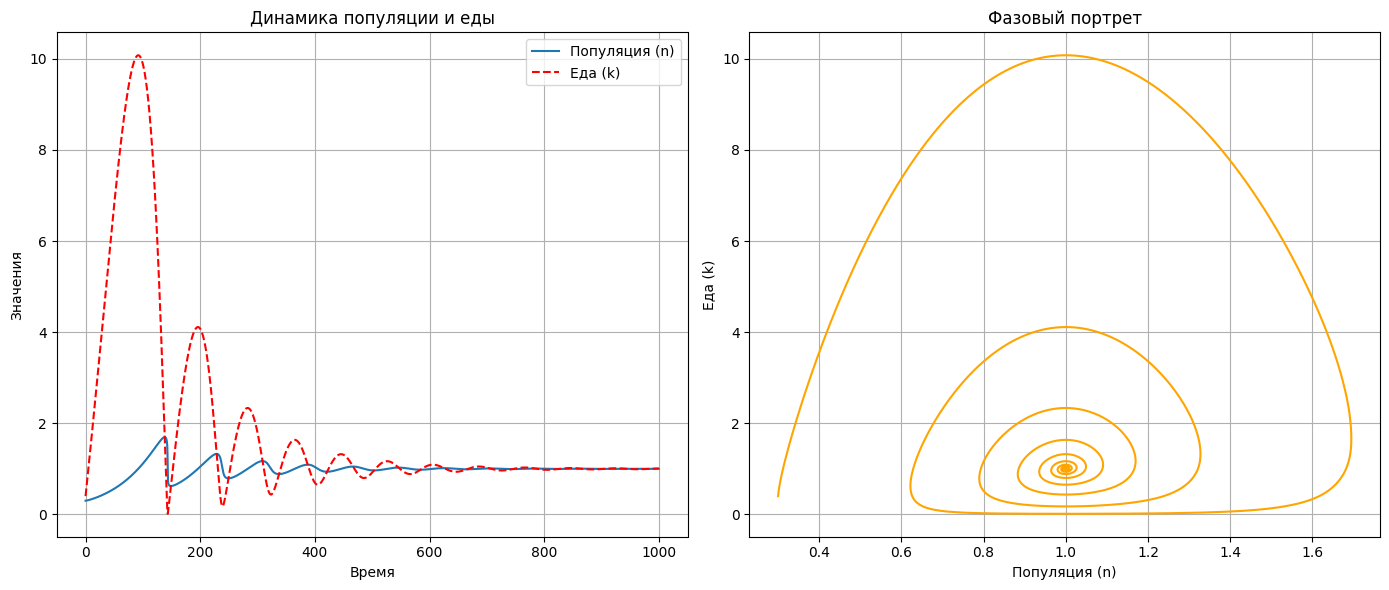

In [ ]:
print(f"Средний период колебаний n: {n_average_period:.2f}")
print(f"Средний период колебаний k: {k_average_period:.2f}")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(t, n, label="Популяция (n)")
ax[0].plot(t, k, label="Еда (k)", c='r', linestyle="--")
ax[0].set_title("Динамика популяции и еды")
ax[0].set_xlabel("Время")
ax[0].set_ylabel("Значения")
ax[0].legend()
ax[0].grid()

ax[1].plot(n, k, c='orange')
ax[1].set_title("Фазовый портрет")
ax[1].set_xlabel("Популяция (n)")
ax[1].set_ylabel("Еда (k)")
ax[1].grid()

plt.tight_layout()
plt.show()

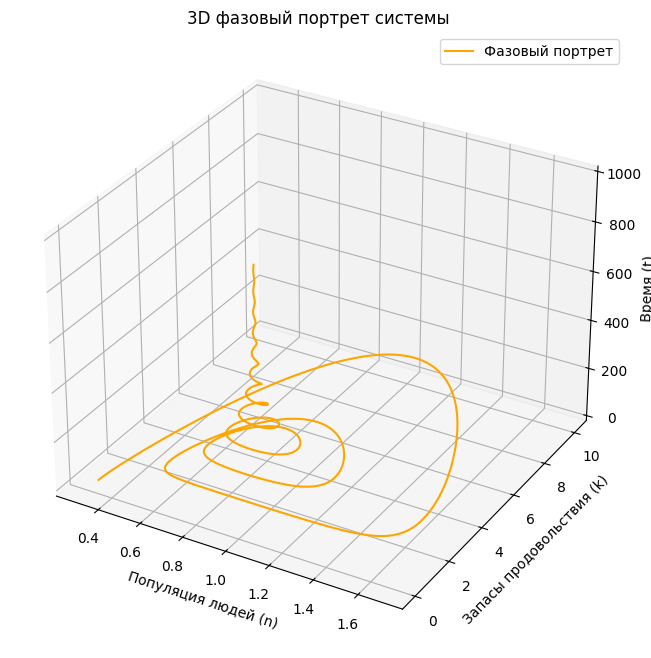

In [ ]:
# Создание 3D графика
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Построение 3D графика
ax.plot(n, k, t, label='Фазовый портрет', c='orange')

# Настройка меток осей
ax.set_xlabel('Популяция людей (n)')
ax.set_ylabel('Запасы продовольствия (k)')
ax.set_zlabel('Время (t)')
ax.set_title('3D фазовый портрет системы')

# Показать легенду
ax.legend()

# Показ графика
plt.show()

Time lag (shift between n and k): 26.60


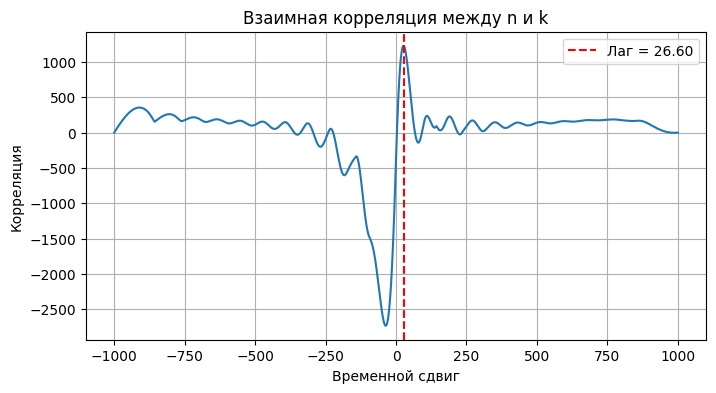

In [ ]:
n_mean = n - np.mean(n)
k_mean = k - np.mean(k)

correlation = np.correlate(n_mean, k_mean, mode="full")
lags = np.arange(-len(n) + 1, len(n)) * (t[1] - t[0])
lag_max = lags[np.argmax(correlation)]

print(f"Time lag (shift between n and k): {lag_max:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(lags, correlation)
plt.axvline(x=lag_max, color='r', linestyle='--', label=f'Лаг = {lag_max:.2f}')
plt.title("Взаимная корреляция между n и k")
plt.xlabel("Временной сдвиг")
plt.ylabel("Корреляция")
plt.legend()
plt.grid()
plt.show()

### Гипотеза о логарифмическом затухании

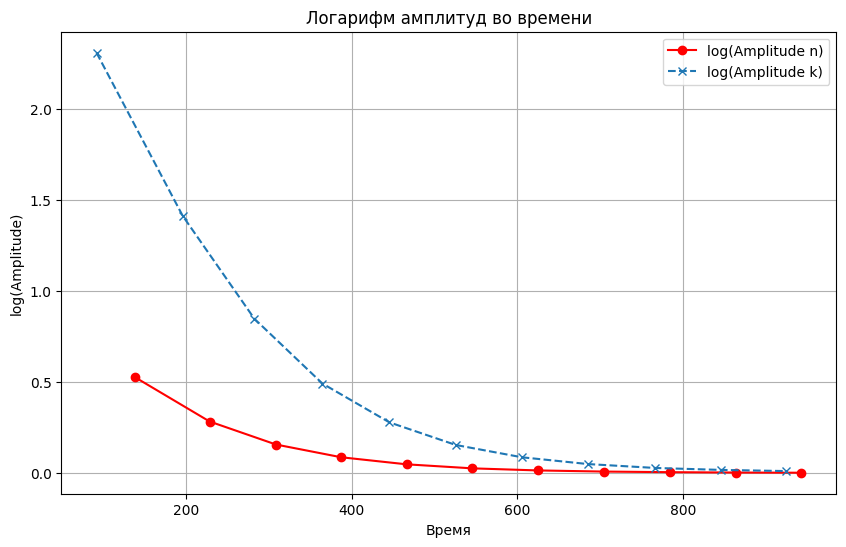

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(n_peak_times, log_n_amplitudes, 'ro-', label="log(Amplitude n)")
plt.plot(k_peak_times, log_k_amplitudes, 'x--', label="log(Amplitude k)")
plt.title("Логарифм амплитуд во времени")
plt.xlabel("Время")
plt.ylabel("log(Amplitude)")
plt.legend()
plt.grid()
plt.show()

Пусть $y = a \cdot e^{-k \cdot t} + c$

Parameters for N: a=2.175, k=0.008291, c=1.002
Parameters for K: a=23.119, k=0.010229, c=1.040


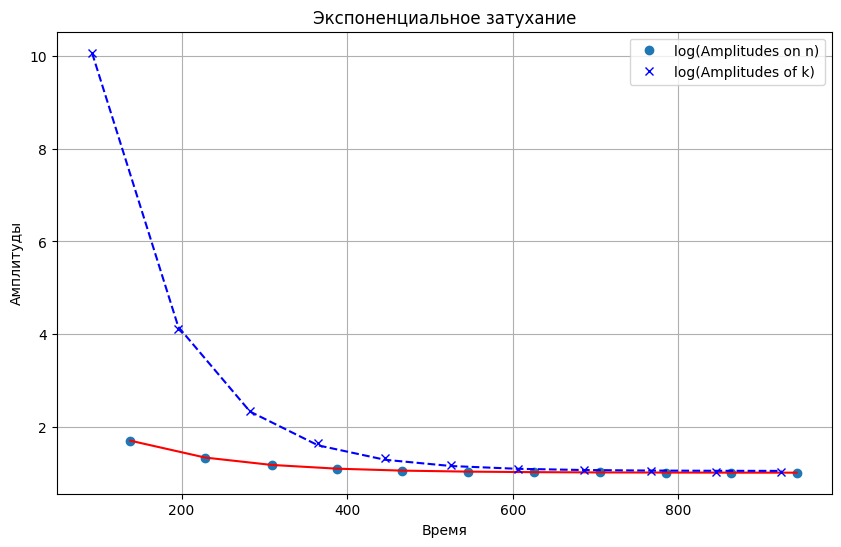

In [ ]:
def model(t, a, k, c):
    return a * np.exp(-k * t) + c

n_params, _ = curve_fit(model, n_peak_times, n_amplitudes, p0=(2.5, 0.001, 0.2))
k_params, _ = curve_fit(model, k_peak_times, k_amplitudes, p0=(2.5, 0.001, 0.2))

n_a, n_k, n_c = n_params
print(f"Parameters for N: a={n_a:.3f}, k={n_k:.6f}, c={n_c:.3f}")

k_a, k_k, k_c = k_params
print(f"Parameters for K: a={k_a:.3f}, k={k_k:.6f}, c={k_c:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(n_peak_times, n_amplitudes, 'o', label="log(Amplitudes on n)")
plt.plot(n_peak_times, model(n_peak_times, *n_params), c='r', linestyle='-')
plt.plot(k_peak_times, k_amplitudes, 'bx', label="log(Amplitudes of k)")
plt.plot(k_peak_times, model(k_peak_times, *k_params), 'b--')
plt.title("Экспоненциальное затухание")
plt.xlabel("Время")
plt.ylabel("Амплитуды")
plt.legend()
plt.grid()
plt.show()